# 01.数据集加载

**往下四个函数，分别是第一次处理，第二次处理，转换函数，划分数据集函数**

In [9]:
# def data_read_and_crop
import os
from PIL import Image
from tqdm import tqdm
def data_read_and_crop(labels,input_dir,output_dir):
    # labels = ['benign', 'malignant', 'normal']
    # input_dir = r"D:\Dataset\Dataset_BUSI_with_GT"
    # output_dir = r"D:\Final_Result\OverlayedImages"
    print('data_read_and_crop start!')
    os.makedirs(output_dir, exist_ok=True)
    for label in labels:
        os.makedirs(os.path.join(output_dir, label), exist_ok=True)

    # Function to overlay images and masks, resize if needed, and save the result
    def overlay_and_save(image_path, mask_path, output_path):
        try:
            # Check if both image and mask files exist
            if os.path.exists(image_path) and os.path.exists(mask_path):
                # Open the actual image and mask image
                image = Image.open(image_path)
                mask = Image.open(mask_path)

                # Ensure both images have the same color mode
                if image.mode != mask.mode:
                    mask = mask.convert(image.mode)

                # Resize the images if their sizes don't match
                if image.size != mask.size:
                    image = image.resize(mask.size)

                # Overlay the image with the mask
                overlayed = Image.blend(image, mask, alpha=0.5)

                # Save the overlayed image to the appropriate label folder
                label = os.path.basename(os.path.dirname(image_path))
                output_path = os.path.join(output_dir, label, os.path.basename(image_path))
                overlayed.save(output_path)
            else:
                #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
                pass
        except Exception as e:
            print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

    # Iterate through the subdirectories (benign, malignant, normal)
    for label in labels:
        print('labels:',label)
        label_dir = os.path.join(input_dir, label)
        if os.path.isdir(label_dir):
            for image_filename in tqdm(os.listdir(label_dir)):
                if image_filename.endswith('.png'):
                    image_path = os.path.join(label_dir, image_filename)
                    # Construct the mask file path based on the naming convention
                    mask_filename = image_filename.replace('.png', '_mask.png')
                    mask_path = os.path.join(label_dir, mask_filename)
                    overlay_and_save(image_path, mask_path, output_dir)

    print("Overlayed images have been saved to D:\Final_Result\OverlayedImages directory.")


In [10]:
# def dataset_divide
import os
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
def dataset_divide(input_dir,output_dir):
    print('dataset_divide start~')
    # Set the path to your input folder
    # labels = ['malignant', 'normal','benign']
    # input_dir = r"D:\Final_Result\OverlayedImages"
    # output_dir = r"D:\Final_Result"
    # Create a list to store file paths and labels
    labels = []
    file_paths = []
    # Loop through the subdirectories (benign, malignant, normal)
    for label in os.listdir(input_dir):
        print('labels:',label)
        label_dir = os.path.join(input_dir, label)
        if os.path.isdir(label_dir):
            for image_file in tqdm(os.listdir(label_dir)):
                if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                         image_file.endswith('_mask_1.png') or
                                                         image_file.endswith('_mask_2.png')):
                    image_path = os.path.join(label_dir, image_file)
                    labels.append(label)
                    file_paths.append(image_path)

    # Create a DataFrame to store the file paths and labels
    data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

    # Split the dataset into train, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
    train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

    # Define the paths for the train, validation, and test directories

    train_dir = os.path.join(output_dir,'train')
    val_dir = os.path.join(output_dir,'validation')
    test_dir = os.path.join(output_dir,'test')

    # Create the train, validation, and test directories and subdirectories
    for label in os.listdir(input_dir):
        os.makedirs(os.path.join(train_dir, label), exist_ok=True)
        os.makedirs(os.path.join(val_dir, label), exist_ok=True)
        os.makedirs(os.path.join(test_dir, label), exist_ok=True)

    # Copy the images to the corresponding directories
    for _, row in train_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(train_dir, label))

    for _, row in val_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(val_dir, label))

    for _, row in test_data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(test_dir, label))
    print('Dataset divided over!')

In [11]:
# def data_transforms
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
def data_transforms(datasets_class):

    # Define the minority classes in your dataset
    class_names = ['malignant', 'normal','benign']
    minority_classes = ['malignant', 'normal']

    # Define custom data transformations for minority classes
    minority_class_transforms = transforms.Compose([
        RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
        RandomRotation(15, expand=False, center=None),
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ])
    if datasets_class == 'train':
        f = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            # Apply custom augmentations to minority classes
            transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        f = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return f

In [12]:
# def data_loading
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# from Data_Operations.Data_Augmentation.Data_Transforms import data_transforms
def data_loading(data_dir):
    # data_dir = r"D:\Final_Result"

    # Create datasets for train, validation, and test
    image_datasets = {
        x: ImageFolder(
            root=os.path.join(data_dir, x),
            transform=data_transforms(x)
        )
        for x in ['train', 'validation', 'test']
    }

    # Specify batch size for dataloaders
    batch_size = 32  # You can adjust this based on your hardware and preferences

    # Create dataloaders for train, validation, and test
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                   for x in ['train', 'validation', 'test']}

    # Calculate dataset sizes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

    # Get class labels
    class_names = image_datasets['train'].classes

    # Print dataset sizes and class labels
    print("Dataset Sizes:", dataset_sizes)
    print("Class Labels:", class_names)
    return image_datasets,dataloaders,dataset_sizes



**往上是数据集加载的四个函数，分别是第一次处理，第二次处理，转换函数，划分数据集**

# 02.模型及评估

**往下是模型的下载，训练模型主体函数，评估函数**

In [13]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#If pretained is not working, you can also use weights instead.

import torch.nn as nn
from torchvision.models import resnet50
def Resnet50(labels):
    # labels = ['malignant', 'normal','benign']
    resnet50_model= resnet50(pretrained=True)

    # print(resnet50)

    for param in resnet50_model.parameters():
        param.requires_grad = True

    #Get the number of Input features of Resnet last fully connected layer
    #because we are going to replace it with new fully connected layer.
    in_features = resnet50_model.fc.in_features

    #Reset the final fully connected layer of the of the pre-trained Resnet.
    resnet50_model.fc = nn.Linear(in_features, len(labels))
    print('Resnet50  finished!')
    return resnet50_model

In [14]:
import time
import copy
import torch
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

# Define the training function with early stopping and additional features
# Lists to store training and validation losses
# train_losses = []
# val_losses = []


def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names,
                                    device, train_losses, val_losses,  num_epochs=20, patience=2):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0
    for epoch in tqdm(range(num_epochs)):
        print('-' * 50)
        print('---Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 3)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # print('Iterate over data~')
            # print()
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Append training loss here
                if phase == 'train':
                    train_losses.append(loss.item())  # Append training loss
                else:
                    val_losses.append(loss.item())  # Append validation loss

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1

                val_losses.append(epoch_loss)

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return model

In [15]:
import torch


from torch.optim import lr_scheduler
import torch.optim as optim
from torch import nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
def loss_with_evaluate(model):
    optimizer = optim.Adam(model.parameters(), lr=0.00005)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    #Define loss functions
    Loss_Function = nn.CrossEntropyLoss()
    return optimizer,scheduler,Loss_Function


def Evaluate(class_names,model,device,dataloaders,train_losses,val_losses):
    # Define label names
    # class_names = ['malignant', 'normal', 'benign']
    label_names = class_names

    # Calculate classification report and confusion matrix on unseen test data
    y_true = []
    y_pred = []

    model_fineTuning = model
    model_fineTuning.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_fineTuning(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

    # Generate confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix with label names
    plt.figure(figsize=(5, 3))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names,
                yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # calculate the percentage
    confusion_mtx_percent = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

    f, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()
    # Convert the classification report to a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues',
                fmt='.2f')  # Simplify classification report
    plt.title('Classification Report Heatmap')
    plt.show()

    # Print the simplified classification report
    print("Simplified Classification Report:")
    print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display without support and avg/total rows
    # Plotting the training and validation losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



**往上是模型的下载，训练模型主体函数，评估函数**

加载数据集:呜呜呜~
data_read_and_crop start!
labels: malignant


100%|██████████| 421/421 [00:23<00:00, 17.97it/s]


labels: normal


100%|██████████| 266/266 [00:17<00:00, 15.24it/s]


labels: benign


100%|██████████| 891/891 [00:50<00:00, 17.77it/s]


Overlayed images have been saved to D:\Final_Result\OverlayedImages directory.
dataset_divide start~
labels: benign


100%|██████████| 437/437 [00:00<00:00, 202890.29it/s]


labels: normal


100%|██████████| 133/133 [00:00<00:00, 186071.53it/s]


labels: malignant


100%|██████████| 210/210 [00:00<00:00, 194309.25it/s]


Dataset divided over!


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


Resnet50  finished!
Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']
Model train~


  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------
---Epoch 0/19
train Loss: 0.5924 Acc: 0.8277


  5%|▌         | 1/20 [00:06<01:59,  6.30s/it]

validation Loss: 0.1716 Acc: 0.9600

--------------------------------------------------
---Epoch 1/19
train Loss: 0.1308 Acc: 0.9734


 10%|█         | 2/20 [00:11<01:40,  5.56s/it]

validation Loss: 0.0711 Acc: 0.9700

--------------------------------------------------
---Epoch 2/19
train Loss: 0.0749 Acc: 0.9805


 15%|█▌        | 3/20 [00:16<01:30,  5.34s/it]

validation Loss: 0.0869 Acc: 0.9500

--------------------------------------------------
---Epoch 3/19
train Loss: 0.0765 Acc: 0.9805


 15%|█▌        | 3/20 [00:21<02:00,  7.09s/it]

validation Loss: 0.0876 Acc: 0.9600
Early stopping after 3 epochs
Training complete in 0m 21s
Best val Loss: 0.0711


              precision    recall  f1-score   support

   malignant       0.95      1.00      0.97        56
      normal       1.00      0.89      0.94        27
      benign       1.00      1.00      1.00        17

    accuracy                           0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100

Confusion Matrix:
[[56  0  0]
 [ 3 24  0]
 [ 0  0 17]]
torch.save~
Evaluate~


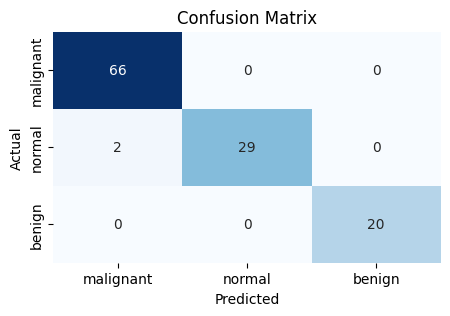

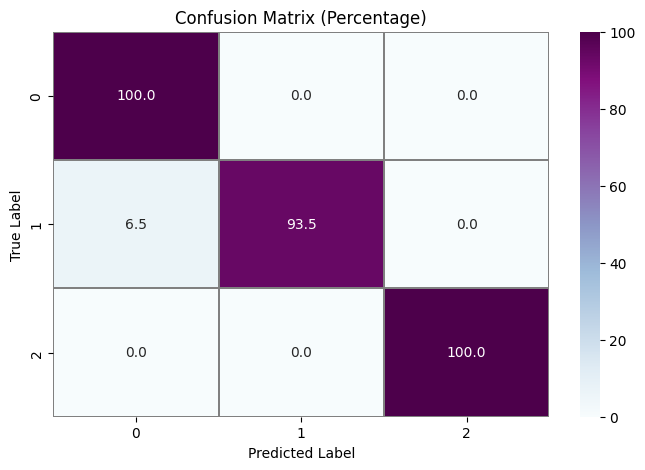

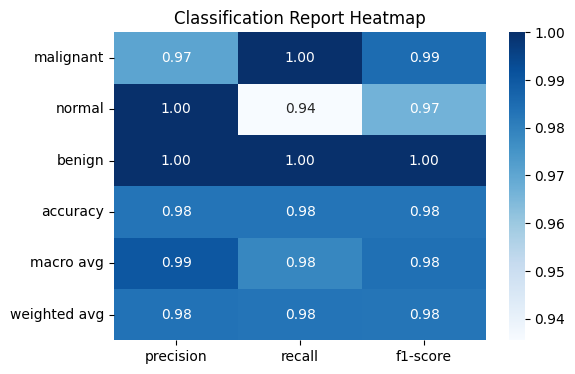

Simplified Classification Report:
           malignant    normal  benign  accuracy  macro avg  weighted avg
precision   0.970588  1.000000     1.0  0.982906   0.990196      0.983409
recall      1.000000  0.935484     1.0  0.982906   0.978495      0.982906
f1-score    0.985075  0.966667     1.0  0.982906   0.983914      0.982749


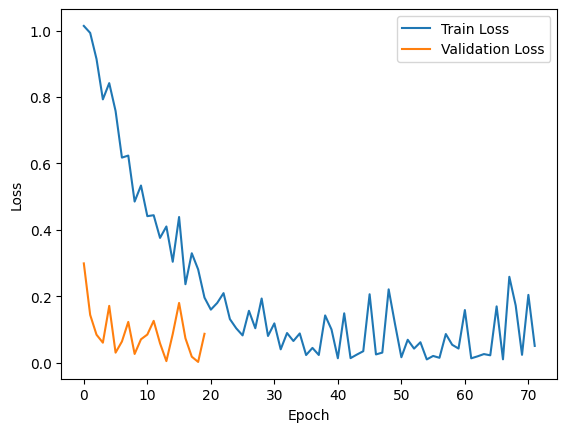

In [16]:
import os
import torch
import warnings
import shutil  
from multiprocessing import freeze_support


if __name__ == '__main__':
    freeze_support()
    
#     temp = '/kaggle/working/'
#     if os.path.exists(temp):
#         shutil.rmtree('/kaggle/working/')  
#         os.makedirs('/kaggle/working/',exist_ok=True)  
#     else:
#         pass
#     print('clear finish~')
    ###
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=ResourceWarning)
    ###

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    labels = ['malignant', 'normal','benign']
    data_dir = '/kaggle/working/'

    ####加载数据集
    print('加载数据集:呜呜呜~')
    # crop第一次处理
    input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
    output_dir = '/kaggle/working/OverlayedImages'
    result_dir = '/kaggle/working/'
    data_read_and_crop(labels=labels,input_dir=input_dir,output_dir=output_dir)
    # divide_with_transforms第二次处理
    dataset_divide(input_dir=output_dir,output_dir=result_dir)


    save_model_pkl_path = r"D:\Final_Result\Resnet50_pkl"
    os.makedirs(save_model_pkl_path, exist_ok=True)
    save_model_pkl_path = os.path.join(save_model_pkl_path,'resnet50_fineTuning.h5')

    resnet50=Resnet50(labels=labels)
    resnet50.to(device=device)
    optimizer,scheduler,Loss_Function = loss_with_evaluate(model=resnet50)
    image_datasets,dataloaders,dataset_sizes = data_loading(data_dir=data_dir)

    train_losses = []
    val_losses = []
    print('Model train~')
    BCI_Model = train_model_with_early_stopping(
        model=resnet50,
        lossFunction=Loss_Function,
        optimizer=optimizer,
        scheduler=scheduler,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        class_names=labels,
        device=device,
        train_losses=train_losses,
        val_losses=val_losses,
        num_epochs=20,
        patience=2
    )
    print('torch.save~')
    torch.save(BCI_Model, save_model_pkl_path)
    print('Evaluate~')
    Evaluate(
        class_names=labels,
        model=resnet50,
        device=device,
        dataloaders=dataloaders,
        train_losses=train_losses,
        val_losses=val_losses
    )


最后放一个测试的函数，并没有用到，毕竟模型都训练完了还要测试什么~

In [17]:
import os
import torch

# Function to count the number of files in a directory
def test_crop_dir(labels,input_dir,output_dir):
    print('test_crop_dir start!')
    def count_files_in_directory(directory):
        return sum(len(files) for _, _, files in os.walk(directory))

    # labels = ['benign', 'malignant', 'normal']
    # input_dir = r"D:\Dataset\Dataset_BUSI_with_GT"
    # output_dir = r"D:\Final_Result\OverlayedImages"

    # Count the files in the input and output directories
    input_counts = {}
    output_counts = {}

    # Count files in input directory
    for label in labels:
        label_dir = os.path.join(input_dir, label)
        if os.path.isdir(label_dir):
            input_counts[label] = count_files_in_directory(label_dir)

    # Count files in output directory
    for label in labels:
        label_dir = os.path.join(output_dir, label)
        if os.path.isdir(label_dir):
            output_counts[label] = count_files_in_directory(label_dir)

    # Print file counts
    print("File Counts Before Overlay-includes masks:")
    for label, count in input_counts.items():
        print(f"{label}: {count} files")

    print("\nFile Counts After Overlay:")
    for label, count in output_counts.items():
        print(f"{label}: {count} files")
    print('test_crop_dir over!')
    
def test_dataset_divide(data_dir):
    print('test_dataset_divide start!')

    train_dir = os.path.join(data_dir,'train')

    # List the subdirectories (benign, malignant, normal)
    subdirectories = ['benign', 'malignant', 'normal']

    # Dictionary to store file counts
    file_counts = {}

    # Loop through the subdirectories and count files in each
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(train_dir, subdirectory)
        if os.path.exists(subdirectory_path):
            file_count = len(os.listdir(subdirectory_path))
            file_counts[subdirectory] = file_count

    # Print the file counts
    for category, count in file_counts.items():
       # print("Train folder counts including masks:")
        print(f"Train {category}: {count}")

    val_dir = os.path.join(data_dir,'validation')

    # List the subdirectories (benign, malignant, normal)
    subdirectories = ['benign', 'malignant', 'normal']

    # Dictionary to store file counts
    file_counts = {}

    # Loop through the subdirectories and count files in each
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(val_dir, subdirectory)
        if os.path.exists(subdirectory_path):
            file_count = len(os.listdir(subdirectory_path))
            file_counts[subdirectory] = file_count

    # Print the file counts
    for category, count in file_counts.items():
        #print("Validation folder counts including masks:")
        print(f"Validation {category}: {count}")


    test_dir = os.path.join(data_dir,'test')

    # List the subdirectories (benign, malignant, normal)
    subdirectories = ['benign', 'malignant', 'normal']

    # Dictionary to store file counts
    file_counts = {}

    # Loop through the subdirectories and count files in each
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(test_dir, subdirectory)
        if os.path.exists(subdirectory_path):
            file_count = len(os.listdir(subdirectory_path))
            file_counts[subdirectory] = file_count

    # Print the file counts
    for category, count in file_counts.items():
        #print("test folder counts including masks:")
        print(f"test {category}: {count}")
    print('test_dataset_divide over!')


from torch.utils.data import DataLoader
def test_val_with_acc(device,model,image_datasets):

    # Set the number of images to display
    num_images_to_display = 15

    # Create a DataLoader for the test dataset
    test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

    # Get a batch of test data
    inputs, labels = next(iter(test_dataloader))

    # Move inputs to the device
    inputs = inputs.to(device)

    # Convert images to grayscale
    grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

    # Get model predictions

    model_fineTuning = model
    with torch.no_grad():

        model_fineTuning.eval()
        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)